In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import bayesflow as bf
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from src.AmortizedMixture import *
from src.models.NormalMixture import *
from src.helpers import *

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# load the generative model
model = NormalMixture(n_cls=2, n_obs=[30, 220], n_rep=[1,10], separation=3.0, seed=1)
model.prior_means = [0.00, -1.5, 1.00]
model.prior_sds   = [1.14,  1.0, 0.65]

# Load pretrained amortizers

## Load Amortized Mixture

In [3]:
mixture = bf.trainers.Trainer(
    amortizer=AmortizedMixture(
        inference_net=IndependentClassificator(num_outputs=model.n_cls, num_dense=8, dropout=False),
        local_summary_net  = bf.networks.DeepSet(summary_dim=1),
        global_summary_net = bf.networks.SetTransformer(input_dim=1, summary_dim=model.n_par*2)
        ), 
    generative_model=model, 
    configurator=lambda x: x, checkpoint_path="checkpoints/mixture")

INFO:root:Loaded loss history from checkpoints/mixture/history_100.pkl.
INFO:root:Networks loaded from checkpoints/mixture/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Load Amortized Posterior 

In [4]:
posterior=bf.trainers.Trainer(
    amortizer=bf.amortizers.AmortizedPosterior(
            inference_net=bf.networks.InvertibleNetwork(num_params=model.n_par, num_coupling_layers=10, coupling_design="spline"), 
            summary_net=bf.networks.HierarchicalNetwork(
                [bf.networks.DeepSet(summary_dim=1), 
                 bf.networks.SetTransformer(input_dim=1, summary_dim=model.n_par*2)]
            ),
            summary_loss_fun="MMD"
    ),
    generative_model=model,
    configurator=lambda x: x, 
    checkpoint_path="checkpoints/posterior"
)

INFO:root:Loaded loss history from checkpoints/posterior/history_50.pkl.
INFO:root:Networks loaded from checkpoints/posterior/ckpt-50
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Load Amortized Mixture Posterior

In [5]:
local_summary_net = bf.networks.DeepSet(summary_dim=1)
mixture_posterior = bf.trainers.Trainer(
    amortizer=AmortizedMixturePosterior(
        amortized_mixture=AmortizedMixture(
            inference_net=IndependentClassificator(num_outputs=model.n_cls, num_dense=12, dropout=False),
            local_summary_net=local_summary_net
        ),
        amortized_posterior=bf.amortizers.AmortizedPosterior(
            inference_net=bf.networks.InvertibleNetwork(num_params=model.n_par, num_coupling_layers=12, coupling_design="spline"), 
            summary_net=bf.networks.HierarchicalNetwork(
                [local_summary_net, 
                  bf.networks.SetTransformer(input_dim=1, summary_dim=model.n_par*2)]
                )
        )
    ), 
    generative_model=model, 
    configurator=lambda x: x, 
    checkpoint_path="checkpoints/mixture_posterior")

INFO:root:Loaded loss history from checkpoints/mixture_posterior/history_100.pkl.
INFO:root:Networks loaded from checkpoints/mixture_posterior/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Experiment: Calibration of classification probabilities

In [6]:
# generate synthetic data from a normal mixture with 
# 25% in class 1 and 75% in class 2
# mu_1=-1 and mu_2=1
parameters = {
    "p": np.array([0.4, 0.6]),
    "mu": np.array([-1.2, 1.0])
}
context = {
    "n_obs": 100,
    "n_rep": 1
}
latents, observables = model._simulator(
    parameters=parameters, 
    context=context).values()

# let's order the observables
ind = np.argsort(np.mean(observables, axis=1))
observables = observables[ind, ...]


bf_data = model.config_bayesflow(context, observables)

### Estimate classification probabilities with amortized mixture

In [7]:
mixture_probs = mixture.amortizer(bf_data)
mixture_probs = np.array(mixture_probs)[0,:,1]

### Estimate parameters with amortized posterior

In [8]:
posterior_parameters = posterior.amortizer.sample(bf_data, n_samples=4000)

### Estimate classification probabilities with amortized mixutre posterior

In [9]:
post_samples, post_probs = mixture_posterior.amortizer.sample(bf_data, n_samples=4000)
mixture_posterior_pars = post_samples[0]
mixture_posterior_probs = post_probs[0,:,:,1]

### Estimate classification probabilities with Stan

In [12]:
stan_model = CmdStanModel(stan_file=os.path.join('..', '..', 'stan', 'normal-mixture.stan'))

DEBUG:cmdstanpy:found newer exe file, not recompiling


In [13]:
stan_data = {
    "n_obs": context['n_obs'],
    "n_rep": context['n_rep'],
    "n_cls": model.n_cls,
    "y": observables,
    "separation": model.separation,
    "alpha": model.alpha
}

In [14]:
stan_fit = stan_model.sample(stan_data, adapt_delta=0.95)

DEBUG:cmdstanpy:cmd: /Users/simonkucharsky/projects/bayesflow/amortized-mixture/stan/normal-mixture info
cwd: None
DEBUG:cmdstanpy:input tempfile: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/m9uzpd8l.json
17:15:29 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/simonkucharsky/projects/bayesflow/amortized-mixture/stan/normal-mixture', 'id=1', 'random', 'seed=4844', 'data', 'file=/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/m9uzpd8l.json', 'output', 'file=/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/normal-mixturefyyp4lvo/normal-mixture-20240508171529_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
DEBUG:cmdstanpy:runn


17:15:29 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/Users/simonkucharsky/projects/bayesflow/amortized-mixture/stan/normal-mixture', 'id=1', 'random', 'seed=4844', 'data', 'file=/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/m9uzpd8l.json', 'output', 'file=/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/normal-mixturefyyp4lvo/normal-mixture-20240508171529_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/normal-mixturefyyp4lvo/normal-mixture-20240508171529_1.csv
 console_msgs (if any):
	/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/normal-mixturefyyp4lvo/normal-mixture-20240508171529_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
metho

In [15]:
print(stan_fit.diagnose())

DEBUG:cmdstanpy:cmd: /Users/simonkucharsky/.cmdstan/cmdstan-2.34.1/bin/diagnose /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/normal-mixturefyyp4lvo/normal-mixture-20240508171529_1.csv /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/normal-mixturefyyp4lvo/normal-mixture-20240508171529_2.csv /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/normal-mixturefyyp4lvo/normal-mixture-20240508171529_3.csv /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/normal-mixturefyyp4lvo/normal-mixture-20240508171529_4.csv
cwd: None


Processing csv files: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/normal-mixturefyyp4lvo/normal-mixture-20240508171529_1.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/normal-mixturefyyp4lvo/normal-mixture-20240508171529_2.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/normal-mixturefyyp4lvo/normal-mixture-20240508171529_3.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpxtfgya_6/normal-mixturefyyp4lvo/normal-mixture-20240508171529_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [16]:
stan_probs=stan_fit.draws_pd(vars=["class_membership"])
stan_probs=stan_probs.iloc[:,stan_data['n_obs']:]
stan_probs=np.array(stan_probs)

### Compare results

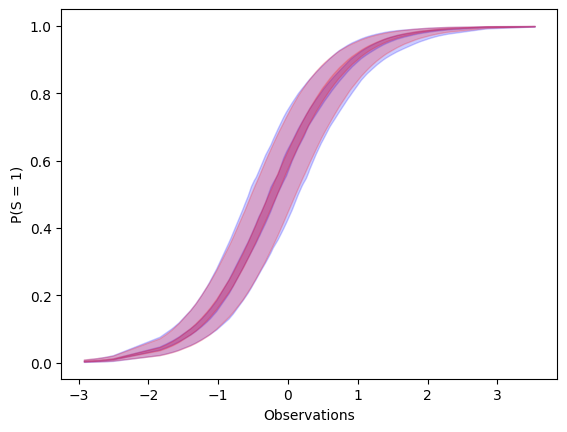

In [17]:
plot_bands(np.mean(observables, axis=1), mixture_posterior_probs, color="blue", alpha=0.2)
plot_bands(np.mean(observables, axis=1), stan_probs, color="red", alpha=0.2)
#plt.scatter(np.mean(observables, axis=1), mixture_probs, color="green", alpha=0.2, marker=".")
plt.xlabel("Observations")
f=plt.ylabel("P(S = 1)")

In [18]:
stan_p = np.array(stan_fit.draws_pd(vars="p"))
mixture_posterior_p = model.extract_pars(mixture_posterior_pars)['p']
posterior_p = model.extract_pars(posterior_parameters)['p']

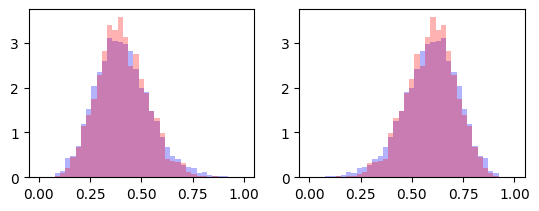

In [20]:
for i in range(2):
    plt.subplot(2, 2, i+1)
    f=plt.hist(mixture_posterior_p[:,i], alpha=0.3, color="blue", bins = np.linspace(0, 1, 40), density=True)
    #f=plt.hist(posterior_p[:,i], alpha=0.3, color="green", bins = np.linspace(0, 1, 40), density=True)
    f=plt.hist(stan_p[:,i], alpha=0.3, color="red", bins = np.linspace(0, 1, 40), density=True)

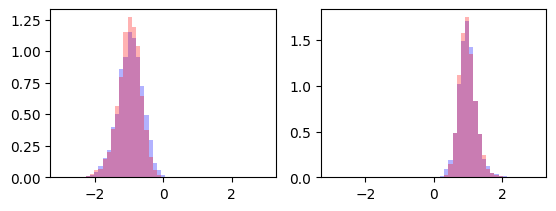

In [21]:
stan_mu = np.array(stan_fit.draws_pd(vars="mu"))
mixture_posterior_mu = model.extract_pars(mixture_posterior_pars)['mu']
posterior_mu = model.extract_pars(posterior_parameters)['mu']
for i in range(2):
    plt.subplot(2, 2, i+1)
    f=plt.hist(mixture_posterior_mu[:,i], alpha=0.3, color="blue", bins=np.linspace(-3, 3, 50), density=True)
    #f=plt.hist(posterior_mu[:,i], alpha=0.3, color="green", bins=np.linspace(-3, 3, 50), density=True)
    f=plt.hist(stan_mu[:,i], alpha=0.3, color="red", bins=np.linspace(-3, 3, 50), density=True)